In [1]:
import pandas as pd

In [2]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet 

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=47a4e7364f0f270ce5fdbdd4b01cb76e78226f39129901d6288f02afadc2486c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
!pip install -q --upgrade fastcore fastai
!pip install --upgrade torch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [4]:
import random 
import numpy as np
import torch
    
def random_seed(dls,seed_value):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    dls.rng.seed(seed_value)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [5]:
from fastai.vision.all import *
pd.options.mode.chained_assignment = None
train = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Train.csv')
test = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Test.csv')
submission = pd.read_csv("../input/csv-files-for-microsoft-rice-disease/SampleSubmission.csv")

In [6]:
train

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
...,...,...
5335,id_zz6gzk7p97_rgn.jpg,brown
5336,id_zz8ca2p67e.jpg,blast
5337,id_zz8ca2p67e_rgn.jpg,blast
5338,id_zzt8y9q0x0.jpg,brown


In [7]:
unique_label = train['Label'].unique()
unique_label

array(['blast', 'brown', 'healthy'], dtype=object)

In [8]:
train['Label'].value_counts()

blast      2988
brown      1532
healthy     820
Name: Label, dtype: int64

In [9]:
train = train[~train.Image_id.str.contains('_rgn')]
train.reset_index(inplace=True,drop=True)
test = test[~test.Image_id.str.contains('_rgn')]
test.reset_index(inplace=True,drop=True)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['Label']=le.fit_transform(train['Label'])

In [11]:
img=Image.open('../input/microsoft-rice-disease-classification-challenge/id_004wknd7qd_rgn.jpg') # View one image and check the files are present
img.shape

(1500, 2000)

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()
import gc; gc.collect()

133

In [13]:
!nvidia-smi

Sat Jun 11 22:54:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
!pip install timm
from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 KB 7.2 MB/s eta 0:00:00


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.386038,0.239365,0.076779,0.923221,05:14


Better model found at epoch 0 with valid_loss value: 0.23936507105827332.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.194449,0.151177,0.056180,0.943820,05:15
1,0.128322,0.124825,0.048689,0.951311,05:15
2,0.129251,0.130805,0.050562,0.949438,05:14
3,0.092015,0.113076,0.046816,0.953184,05:15
4,0.069698,0.134044,0.044944,0.955056,05:15
5,0.023290,0.068412,0.026217,0.973783,05:15
6,0.052300,0.074572,0.031835,0.968165,05:14
7,0.016256,0.081758,0.026217,0.973783,05:15
8,0.027533,0.069836,0.016854,0.983146,05:16
9,0.011680,0.093545,0.029963,0.970037,05:15


Better model found at epoch 0 with valid_loss value: 0.151177316904068.
Better model found at epoch 1 with valid_loss value: 0.12482519447803497.
Better model found at epoch 3 with valid_loss value: 0.11307583004236221.
Better model found at epoch 5 with valid_loss value: 0.06841208785772324.
Better model found at epoch 10 with valid_loss value: 0.06038447842001915.
Better model found at epoch 11 with valid_loss value: 0.05442935600876808.
Better model found at epoch 13 with valid_loss value: 0.05361083149909973.
Better model found at epoch 17 with valid_loss value: 0.051826220005750656.


0.046339785304136426


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.392641,0.516611,0.205993,0.794007,05:14


Better model found at epoch 0 with valid_loss value: 0.5166109800338745.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.222872,0.193422,0.059925,0.940075,05:14
1,0.150816,0.163557,0.052434,0.947566,05:14
2,0.116491,0.129642,0.046816,0.953184,05:14
3,0.081413,0.117679,0.041199,0.958802,05:15
4,0.073236,0.109016,0.035581,0.964419,05:15
5,0.043161,0.101670,0.024345,0.975655,05:16
6,0.027983,0.071370,0.018727,0.981273,05:17
7,0.019387,0.070016,0.018727,0.981273,05:16
8,0.014075,0.070415,0.018727,0.981273,05:15
9,0.019399,0.088149,0.026217,0.973783,05:15


Better model found at epoch 0 with valid_loss value: 0.19342225790023804.
Better model found at epoch 1 with valid_loss value: 0.16355670988559723.
Better model found at epoch 2 with valid_loss value: 0.12964209914207458.
Better model found at epoch 3 with valid_loss value: 0.11767929792404175.
Better model found at epoch 4 with valid_loss value: 0.10901571810245514.
Better model found at epoch 5 with valid_loss value: 0.10167036205530167.
Better model found at epoch 6 with valid_loss value: 0.07136978209018707.
Better model found at epoch 7 with valid_loss value: 0.07001584768295288.
Better model found at epoch 11 with valid_loss value: 0.06659217178821564.


0.051504831775397074


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.451454,0.392822,0.142322,0.857678,05:15


Better model found at epoch 0 with valid_loss value: 0.3928218483924866.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.113558,0.159996,0.052434,0.947566,05:15
1,0.100432,0.140388,0.048689,0.951311,05:15
2,0.112966,0.162882,0.052434,0.947566,05:15
3,0.073801,0.209974,0.056180,0.943820,05:15
4,0.083179,0.150689,0.043071,0.956929,05:17
5,0.089531,0.211402,0.061798,0.938202,05:16
6,0.057187,0.182363,0.052434,0.947566,05:16
7,0.022233,0.226056,0.054307,0.945693,05:19
8,0.007426,0.307772,0.041199,0.958802,05:17
9,0.022685,0.305345,0.052434,0.947566,05:15


Better model found at epoch 0 with valid_loss value: 0.1599964201450348.
Better model found at epoch 1 with valid_loss value: 0.14038842916488647.
Better model found at epoch 12 with valid_loss value: 0.1133112981915474.


0.11007728546555767


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.474312,0.351321,0.140449,0.859551,05:14


Better model found at epoch 0 with valid_loss value: 0.35132139921188354.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.108034,0.159819,0.067416,0.932584,05:14
1,0.078607,0.164582,0.054307,0.945693,05:14
2,0.055801,0.301977,0.102996,0.897004,05:13
3,0.028218,0.143901,0.035581,0.964419,05:13
4,0.068701,0.262821,0.067416,0.932584,05:14
5,0.149465,0.237883,0.078652,0.921348,05:14
6,0.069803,0.136614,0.052434,0.947566,05:14
7,0.040304,0.182878,0.048689,0.951311,05:14
8,0.041394,0.161445,0.048689,0.951311,05:13
9,0.034741,0.181016,0.039326,0.960674,05:13


Better model found at epoch 0 with valid_loss value: 0.15981876850128174.
Better model found at epoch 3 with valid_loss value: 0.14390085637569427.
Better model found at epoch 6 with valid_loss value: 0.13661405444145203.


0.1323132754417272


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.902092,1.015094,0.441948,0.558052,05:13


Better model found at epoch 0 with valid_loss value: 1.0150943994522095.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.182877,0.181462,0.067416,0.932584,05:14
1,0.087646,0.392925,0.116105,0.883895,05:13
2,0.145976,0.237968,0.073034,0.926966,05:13
3,0.182961,0.128655,0.043071,0.956929,05:13
4,0.140885,0.218360,0.076779,0.923221,05:13
5,0.097708,0.156261,0.037453,0.962547,05:14
6,0.016202,0.182085,0.041199,0.958802,05:14
7,0.022996,0.224908,0.054307,0.945693,05:14
8,0.039483,0.171890,0.048689,0.951311,05:14
9,0.030724,0.167371,0.041199,0.958802,05:13


Better model found at epoch 0 with valid_loss value: 0.18146170675754547.
Better model found at epoch 3 with valid_loss value: 0.12865452468395233.


0.12197610083461817


fold fineshed


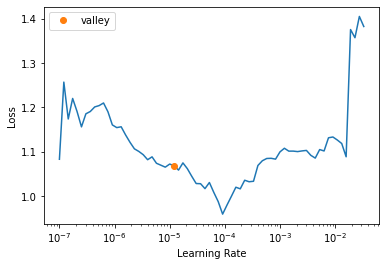

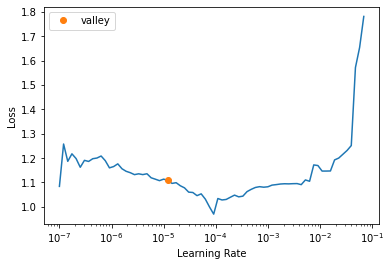

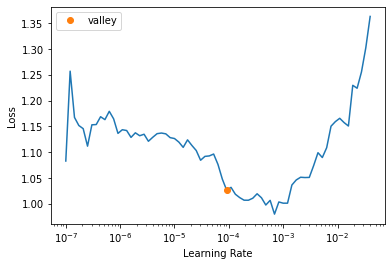

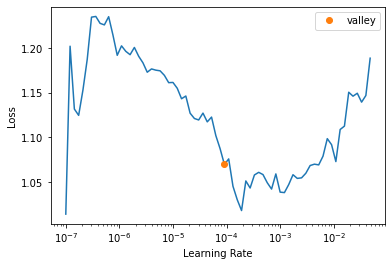

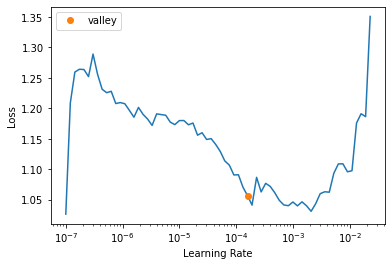

In [15]:
from sklearn.model_selection import StratifiedKFold
from fastai.callback.tracker import SaveModelCallback,EarlyStoppingCallback
import sklearn
from sklearn.metrics import log_loss
tfms = aug_transforms(do_flip = True, flip_vert = False, mult=.0,size=384)
skf=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
y_pred_tot=[]
valid_loglos=[]
i=0
oof = np.zeros((train.shape[0],3))
for train_index, test_index in skf.split(train, train['Label']): 
    train['val_col']=False
    train.loc[test_index,'val_col']=True
    dls = ImageDataLoaders.from_df(train, path='../input/microsoft-rice-disease-classification-challenge',item_tfms=Resize(384),batch_tfms=[Normalize.from_stats(*imagenet_stats)],valid_col='val_col',seed=50,num_workers=1,val_pct=0,bs=4)
    random_seed(dls,50)
    #model = EfficientNet.from_pretrained("efficientnet-b7")
    #model._fc = nn.Linear(model._fc.in_features,3)
    model = create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=3)
    learn = Learner(dls,model,metrics=[error_rate,accuracy],path='.',cbs=[SaveModelCallback(monitor='valid_loss')])
#         learn = cnn_learner(dls,vgg19_bn,metrics=[error_rate,accuracy],path='.',cbs=[EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001, patience=10),SaveModelCallback(monitor='valid_loss')])
    random_seed(dls,50)
    best_lr = learn.lr_find()
    learn.fine_tune(20,best_lr.valley)
    #val
    valid =learn.dls.test_dl(train.iloc[test_index]['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    val_preds = learn.get_preds(dl=valid)
    print(log_loss(train.iloc[test_index]['Label'],val_preds[0]))
    oof[test_index]=val_preds[0]
    #test
    tdl = learn.dls.test_dl(test['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    learn.save("model"+str(i))
    preds = learn.get_preds(dl=tdl)
    y_pred_tot.append(preds)
    print('fold fineshed')
    i=i+1

In [16]:
from sklearn.metrics import log_loss
log_loss(train['Label'].values,oof)

0.09244226422295101

In [17]:
predss=[to_np(x[0])for x in y_pred_tot]
predss


[array([[1.0000000e+00, 2.1407025e-10, 7.9386397e-10],
        [7.3480085e-05, 9.9992645e-01, 9.3086733e-08],
        [8.6936760e-01, 1.3063049e-01, 1.8847780e-06],
        ...,
        [9.9999827e-01, 1.7596160e-06, 8.9663381e-11],
        [9.9999976e-01, 9.4674633e-09, 2.2082133e-07],
        [3.2183330e-04, 2.4625064e-07, 9.9967790e-01]], dtype=float32),
 array([[1.0000000e+00, 2.2483331e-08, 3.1178338e-08],
        [1.3006566e-01, 8.6974454e-01, 1.8979950e-04],
        [9.5056325e-01, 4.9434274e-02, 2.5177176e-06],
        ...,
        [9.8937225e-01, 1.0627754e-02, 4.3241535e-09],
        [9.9998915e-01, 1.6597018e-07, 1.0671119e-05],
        [8.4518990e-04, 8.1597227e-06, 9.9914670e-01]], dtype=float32),
 array([[9.9970889e-01, 2.8950992e-04, 1.6004252e-06],
        [1.1616076e-03, 9.9882495e-01, 1.3402181e-05],
        [9.9491596e-01, 5.0811842e-03, 2.8065222e-06],
        ...,
        [9.9759597e-01, 2.4023945e-03, 1.6521811e-06],
        [9.9999416e-01, 5.3931376e-06, 4.670317

In [18]:
preds=np.mean(predss,0)
preds

array([[9.9977219e-01, 1.7821415e-04, 4.9604580e-05],
       [2.6748944e-02, 9.7272044e-01, 5.3059577e-04],
       [9.4623649e-01, 5.3262375e-02, 5.0110847e-04],
       ...,
       [9.9528009e-01, 4.6430146e-03, 7.6953373e-05],
       [9.9986190e-01, 9.8618177e-05, 3.9454066e-05],
       [1.3013390e-01, 4.4872845e-04, 8.6941737e-01]], dtype=float32)

In [19]:
submission_from_test = test[['Image_id']]
submission_from_test

,Image_id
0,id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg
2,id_030ln10ewn.jpg
3,id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg
...,...
1140,id_zrdlgjrq3r.jpg
1141,id_zsfayxwipp.jpg
1142,id_ztvp2l9k3h.jpg
1143,id_zwwcma7hlt.jpg


In [20]:
le.inverse_transform([0,1,2])

array(['blast', 'brown', 'healthy'], dtype=object)

In [21]:
submission_from_test['blast'] = preds[:,0]
submission_from_test['brown'] = preds[:,1]
submission_from_test['healthy'] = preds[:,2]

In [22]:
submission_from_test

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999772,0.000178,0.000050
1,id_01hu05mtch.jpg,0.026749,0.972720,0.000531
2,id_030ln10ewn.jpg,0.946236,0.053262,0.000501
3,id_03z57m8xht.jpg,0.999993,0.000006,0.000001
4,id_04ngep1w4b.jpg,0.999069,0.000589,0.000343
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,0.000069,0.002445,0.997486
1141,id_zsfayxwipp.jpg,0.000054,0.999862,0.000084
1142,id_ztvp2l9k3h.jpg,0.995280,0.004643,0.000077
1143,id_zwwcma7hlt.jpg,0.999862,0.000099,0.000039


In [23]:
submission_from_test.to_csv("without tta 0.0524.csv",index=False)

In [24]:
np.save('y_pred_tot.npy', y_pred_tot)

/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'TensorImage' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'TensorImage', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [25]:
submission


,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,0.0,0.0,0.0
1141,id_zsfayxwipp.jpg,0.0,0.0,0.0
1142,id_ztvp2l9k3h.jpg,0.0,0.0,0.0
1143,id_zwwcma7hlt.jpg,0.0,0.0,0.0
